## Black-box Vector Optimization on Fairness
This notebook contains a vector optimization example on an ML fairness dataset, and compares Naive Elimination and PaVeBa algorithms.

In [18]:
from copy import deepcopy
from unittest import mock
from typing import Optional

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

import torch
from torch import Tensor
import numpy as np
from botorch.test_functions.base import (
    MultiObjectiveTestProblem,
)
import botorch.test_functions.multi_objective as multi_objective
from scipy.integrate import solve_ivp
from scipy.stats.qmc import Sobol

import optuna
from vopy.utils import set_seed
from vopy.order import ConeTheta2DOrder, ConeOrder3D
from vopy.algorithms import PaVeBaGPOnline
from vopy.maximization_problem import FixedPointsProblem
from vopy.utils.evaluate import calculate_epsilonF1_score

optuna.logging.set_verbosity(optuna.logging.WARNING)

Let's first create an `Order` object to define our preference and visualize it's cone. Our preference correspond to allowing a little trade-off between objectives.

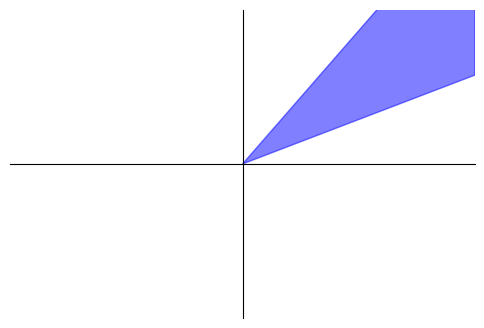

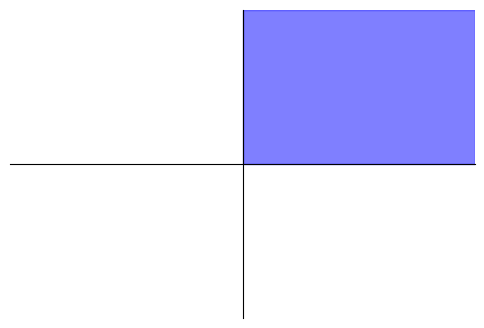

In [19]:
order = ConeTheta2DOrder(cone_degree=30)
order_mo = ConeTheta2DOrder(cone_degree=90)
# order = ConeOrder3D(cone_type="acute")
fig_cone = order.ordering_cone.plot()
fig_cone_mo = order_mo.ordering_cone.plot()

Now, we will create an instance of ML fairness dataset and visualize its Pareto front w.r.t. the order we created. This dataset contains different (200 candidates) hyperparameter selections of ROAD approach on a neural network architecture. The objectives are negative global unfairness measured by disparate impact measure and accuracy of the model. The $x$-axis corresponds to the negative global unfairness and $y$-axis corresponds to the accuracy of the model.

In [20]:
class VdV(MultiObjectiveTestProblem):
    r"""A two objective optimization problem for a Van de Vusse reaction (VdV).

    Design space `x = (tau, temperature)`:
        - `tau` is the residence time.
        - `temperature` is the reactor temperature in degrees celsius.

    Objective `min(-log(product_yield), -log(sty))`:
        - `e_factor` is the product yield.
        - `sty` is the space-time yield.

    This implementation is adapted from the MATLAB code in
    https://github.com/adamc1994/MultiChem
    """

    dim = 2
    num_objectives = 2
    _bounds = [(0.5, 10), (25, 100)]
    _ref_point = [5, 1]

    # Molecular weight
    molecular_weight = 100
    # Avogadro
    R = 8.314
    # Absolute zero
    absolute_zero = 273.15
    # volume
    V = 8
    # discretization
    n = 5
    discrete_v = torch.linspace(0, V, n)
    # initial concentration
    C0 = 1

    def __init__(self, noise_std: Optional[float] = None, negate: bool = True) -> None:
        r"""Constructor for VdV.
        Args:
            noise_std: Standard deviation of the observation noise.
            negate: If True, negate the objectives.
        """
        super().__init__(noise_std=noise_std, negate=negate)

    @classmethod
    def solve_ode(cls, X) -> Tensor:
        """
        Args:
            X: A `batch_shape x d`-dim Tensor containing the designs.

        Returns:
            A `batch_shape x M`-dim Tensor containing the objectives.

        """
        # We consider transforming X into `B x d`-dim Tensor and then performing `B`
        # function evaluations. Certain computations are executed in parallel when
        # simple.
        batch_shape = X.shape[:-1]
        B = torch.prod(torch.tensor(batch_shape))
        new_shape = torch.Size([B]) + torch.Size([cls.dim])
        X_reshaped = X.reshape(new_shape)

        # extract design variables
        tau = X_reshaped[:, 0]
        temperature = X_reshaped[:, 1]

        # concentration
        C_i = torch.zeros(B, cls.n * 4)
        C_i[:, 0] = cls.C0

        # Integration step
        # Ideally we should integrate in parallel, but scipy.stats.solve_ivp
        # does not have this feature.
        C_final = np.zeros(shape=(B, 4))
        for b in range(B):
            def _integrand_b(t, concentration, temperature):
                flow_rate = cls.V / tau[b]
                conc = concentration[0:cls.n*4].reshape(4, cls.n)
                T = temperature + cls.absolute_zero

                k = (
                    lambda k_ref, E_a: k_ref * torch.exp(-E_a / (cls.R * T))
                )
                diff = lambda vec: vec[1:] - vec[0:-1]

                k_a = k(2.1450e10, 8.1131e4)
                k_b = k(2.1450e10, 8.1131e4)
                k_c = k(0.0151e10, 7.1168e4)

                A = conc[0, :]
                B = conc[1, :]
                C = conc[2, :]
                D = conc[3, :]

                dAdt = [
                    torch.zeros(1),
                    - flow_rate * diff(A) / diff(cls.discrete_v)
                    - k_a * A[1:] - k_c * A[1:] ** 2
                ]
                dAdt = torch.cat(dAdt)

                dBdt = [
                    torch.zeros(1),
                    - flow_rate * diff(B) / diff(cls.discrete_v)
                    + k_a * A[1:] - k_b * B[1:]
                ]
                dBdt = torch.cat(dBdt)

                dCdt = [
                    torch.zeros(1),
                    - flow_rate * diff(C) / diff(cls.discrete_v)
                    + k_b * B[1:]
                ]
                dCdt = torch.cat(dCdt)

                dDdt = [
                    torch.zeros(1),
                    - flow_rate * diff(D) / diff(cls.discrete_v)
                    + k_c * A[1:] ** 2
                ]
                dDdt = torch.cat(dDdt)

                return torch.cat([dAdt, dBdt, dCdt, dDdt])

            res_b = solve_ivp(
                _integrand_b, [0, 4*tau[b]], C_i[b], args=(temperature[b],)
            )

            C_final[b, :] = torch.tensor(
                [res_b.y[(i+1)*cls.n - 1, -1] for i in range(4)],
                dtype=torch.double
            )
        # Convert numpy array to tensor
        C_final = torch.tensor(C_final, dtype=torch.double)
        product_yield = C_final[:, 1] * 100 / cls.C0
        sty = 60 * C_final[:, 1] * cls.molecular_weight / tau
        obj_values = torch.column_stack(
            [-torch.log(product_yield), -torch.log(sty)]
        )

        return obj_values.reshape(batch_shape + torch.Size([cls.num_objectives]))

    def evaluate_true(self, X: Tensor) -> Tensor:
        return self.solve_ode(X)

class PK2(MultiObjectiveTestProblem):
    r"""A two objective optimization problem for the Paal-Knorr reaction (PK) between
    2,5-hexanedione and ethanolamine.

    Design space `x = (tau, temperature, equivalents)`:
        - `tau` is the residence time.
        - `temperature` is the temperature.
        - `equivalents` is the equivalents of 3.25 (???).

    Objective `min(log(yield), -log(sty))`:
        - `yield` is the yield of 3.26 %.
        - `sty` is the space-time yield.

    This implementation is adapted from the MATLAB code in
    https://github.com/adamc1994/MultiChem
    """

    dim = 3
    num_objectives = 2
    _bounds = [(0.5, 2), (25, 150), (1, 10)]
    _ref_point = [4.5, -3]

    # Molecular weight
    molecular_weight = 139.20
    # Avogadro
    R = 8.314
    # Absolute zero
    absolute_zero = 273.15
    # volume
    V = 8
    # discretization
    n = 5
    discrete_v = torch.linspace(0, V, n)
    # initial concentration
    C0 = 1

    def __init__(self, noise_std: Optional[float] = None, negate: bool = True) -> None:
        r"""Constructor for PK2.
        Args:
            noise_std: Standard deviation of the observation noise.
            negate: If True, negate the objectives.
        """
        super().__init__(noise_std=noise_std, negate=negate)

    @classmethod
    def solve_ode(cls, X) -> Tensor:
        """
        Args:
            X: A `batch_shape x d`-dim Tensor containing the designs.

        Returns:
            A `batch_shape x M`-dim Tensor containing the objectives.

        """
        # We consider transforming X into `B x d`-dim Tensor and then performing `B`
        # function evaluations. Certain computations are executed in parallel when
        # simple.
        batch_shape = X.shape[:-1]
        B = torch.prod(torch.tensor(batch_shape))
        new_shape = torch.Size([B]) + torch.Size([cls.dim])
        X_reshaped = X.reshape(new_shape)

        # extract design variables
        tau = X_reshaped[:, 0]
        temperature = X_reshaped[:, 1]
        equivalents = X_reshaped[:, 2]

        # concentration
        C_i = torch.zeros(B, cls.n * 4)
        C_i[:, 0] = cls.C0
        C_i[:, cls.n] = cls.C0 * equivalents

        # Integration step
        # Ideally we should integrate in parallel, but scipy.stats.solve_ivp
        # does not have this feature.
        C_final = np.zeros(shape=(B, 4))
        for b in range(B):
            def _integrand_b(t, concentration, temperature):
                flow_rate = cls.V / tau[b]
                conc = concentration[0:cls.n*4].reshape(4, cls.n)
                T = temperature + cls.absolute_zero

                k = (
                    lambda k_ref, E_a: k_ref * np.exp(-E_a / (cls.R * T))
                )
                diff = lambda vec: vec[1:] - vec[0:-1]

                k_a = k(15.40, 12.2e3)
                k_b = k(405.19, 20.0e3)

                A = conc[0, :]
                B = conc[1, :]
                C = conc[2, :]
                D = conc[3, :]

                dAdt = [
                    torch.zeros(1),
                    - flow_rate * diff(A) / diff(cls.discrete_v)
                    - k_a * A[1:] * B[1:]
                ]
                dAdt = torch.cat(dAdt)

                dBdt = [
                    torch.zeros(1),
                    - flow_rate * diff(B) / diff(cls.discrete_v)
                    - k_a * A[1:] * B[1:]
                ]
                dBdt = torch.cat(dBdt)

                dCdt = [
                    torch.zeros(1),
                    - flow_rate * diff(C) / diff(cls.discrete_v)
                    + k_a * A[1:] * B[1:] - k_b * C[1:]
                ]
                dCdt = torch.cat(dCdt)

                dDdt = [
                    torch.zeros(1),
                    - flow_rate * diff(D) / diff(cls.discrete_v)
                    + k_b * C[1:]
                ]
                dDdt = torch.cat(dDdt)

                return torch.cat([dAdt, dBdt, dCdt, dDdt])

            res_b = solve_ivp(
                _integrand_b, [0, 4*tau[b]], C_i[b], args=(temperature[b],)
            )

            C_final[b, :] = torch.tensor(
                [res_b.y[(i+1)*cls.n - 1, -1] for i in range(4)],
                dtype=torch.double
            )

        # Convert numpy array to tensor
        C_final = torch.tensor(C_final, dtype=torch.double)
        sty = 60 * C_final[:, 3] * cls.molecular_weight / tau

        # product = C_final[:, 3] * 100
        # rme = (139.20 * product) / (
        #         114.14 + (61.08 * equivalents)
        # )

        intermediate_yield = C_final[:, 2] * 100 / cls.C0

        obj_values = torch.column_stack(
            [torch.log(intermediate_yield), -torch.log(sty)]
        )

        return obj_values.reshape(batch_shape + torch.Size([cls.num_objectives]))

    def evaluate_true(self, X: Tensor) -> Tensor:
        return self.solve_ode(X)


In [ ]:
set_seed(0)

design_count = 300
epsilon = 0.01
delta = 0.05
noise_var = 0.0001
noise_std = noise_var ** 0.5

problem = PK2(noise_std=noise_std, negate=True)
input_bounds = problem._bounds


# Create designs
num_sobol_samples = design_count
sampler = Sobol(problem.dim, scramble=False)
sampler.fast_forward(np.random.randint(low=1, high=max(2, num_sobol_samples)))
samples = sampler.random(num_sobol_samples)

for i, (l, u) in enumerate(input_bounds):
    samples[:, i] = samples[:, i] * (u - l) + l

X_np = samples
X = X_np.tolist()
X = [tuple(x) for x in X]
# Y = problem(torch.tensor(X)).numpy(force=True).tolist()

#### Algorithms
We'll now run both algorithms (Naive Elimination and PaVeBa) and print out their results.

In [23]:
set_seed(0)

paveba_problem = FixedPointsProblem(
    in_points=X_np,
    out_dim=problem.num_objectives,
    objective=lambda x: problem(torch.tensor(x)).numpy(force=True),
)
paveba_alg = PaVeBaGPOnline(
    epsilon=epsilon,
    delta=delta,
    problem=paveba_problem,
    order=order,
    conf_contraction=128,
    initial_sample_cnt=25,
    reset_on_retrain=False,
)

while True:
    is_done = paveba_alg.run_one_step()

    if is_done:
        break

Round 1:There are 56 designs left in set S and 13 designs in set P.
Round 2:There are 36 designs left in set S and 17 designs in set P.
Round 3:There are 35 designs left in set S and 18 designs in set P.
Round 4:There are 29 designs left in set S and 19 designs in set P.
Round 5:There are 28 designs left in set S and 20 designs in set P.
Round 6:There are 24 designs left in set S and 22 designs in set P.
Round 7:There are 20 designs left in set S and 24 designs in set P.
Round 8:There are 20 designs left in set S and 24 designs in set P.
Round 9:There are 18 designs left in set S and 25 designs in set P.
Round 10:There are 17 designs left in set S and 25 designs in set P.
Round 11:There are 17 designs left in set S and 25 designs in set P.
Round 12:There are 17 designs left in set S and 25 designs in set P.
Round 13:There are 13 designs left in set S and 26 designs in set P.
Round 14:There are 13 designs left in set S and 26 designs in set P.
Round 15:There are 13 designs left in set S

In [ ]:
def optuna_objective(trial):
    index = trial.suggest_categorical("tau_temp_equ", list(range(len(X))))

    inp = torch.tensor(X[index]).reshape(1, problem.dim)
    return problem(inp).numpy(force=True).tolist()[0]

def optuna_objective(trial):
    index = trial.suggest_categorical("tau_temp_equ", X)

    inp = torch.tensor(X[index]).reshape(1, problem.dim)
    return problem(inp).numpy(force=True).tolist()[0]

def optuna_objective(trial):
    tau = trial.suggest_float("tau", problem._bounds[0][0], problem._bounds[0][1])
    temperature = trial.suggest_float("temperature", problem._bounds[1][0], problem._bounds[1][1])
    equivalents = trial.suggest_float("equivalents", problem._bounds[2][0], problem._bounds[2][1])
    suggested_point = np.array([tau, temperature, equivalents])

    distances = np.linalg.norm(X_np - suggested_point, axis=1)
    closest_index = np.argmin(distances)
    
    inp = torch.tensor(X_np[closest_index]).reshape(1, problem.dim)
    return problem(inp).numpy(force=True).tolist()[0]

study = optuna.create_study(directions=["maximize", "maximize"])
study.optimize(optuna_objective, n_trials=paveba_alg.sample_count, timeout=120)
print("Number of finished trials: ", len(study.trials))

Number of finished trials:  81


In [25]:
Y_true = problem(torch.tensor(X_np), noise=False).numpy(force=True)

In [26]:
optuna_p_set = set()
for trial in study.best_trials:
    trial_pt = np.array((trial.params["tau"], trial.params["temperature"], trial.params["equivalents"]))
    closest_index = np.argmin(np.linalg.norm(trial_pt - X_np, axis=1))
    optuna_p_set.add(closest_index)
optuna_p_set = list(optuna_p_set)

vopy_p_set = list(paveba_alg.P)

In [27]:
dataset = mock.Mock()
dataset.out_data = Y_true
true_pareto_inds = order.get_pareto_set(Y_true)

vopy_epsf1 = calculate_epsilonF1_score(dataset, order, true_pareto_inds, vopy_p_set, epsilon)
optuna_epsf1 = calculate_epsilonF1_score(dataset, order, true_pareto_inds, optuna_p_set, epsilon)

print("VOPy epsilon-F1 score:", vopy_epsf1)
print("Optuna epsilon-F1 score:", optuna_epsf1)

VOPy epsilon-F1 score: 0.8285714285714286
Optuna epsilon-F1 score: 0.27906976744186046


In [28]:
true_pareto_inds_mo = order_mo.get_pareto_set(Y_true)

vopy_epsf1_mo = calculate_epsilonF1_score(dataset, order_mo, true_pareto_inds_mo, vopy_p_set, epsilon)
optuna_epsf1_mo = calculate_epsilonF1_score(dataset, order_mo, true_pareto_inds_mo, optuna_p_set, epsilon)

print("VOPy epsilon-F1 score:", vopy_epsf1_mo)
print("Optuna epsilon-F1 score:", optuna_epsf1_mo)

VOPy epsilon-F1 score: 0.6382978723404256
Optuna epsilon-F1 score: 0.5555555555555556


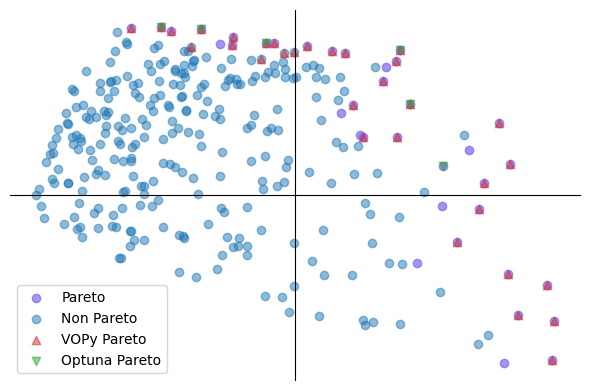

In [29]:
tmp_pareto_fig = order.plot_pareto_set(Y_true)
tmp_pareto_fig.axes[0].scatter(
    dataset.out_data[vopy_p_set][:, 0],
    dataset.out_data[vopy_p_set][:, 1],
    c="tab:red", label="VOPy Pareto", alpha=0.5, marker="^"
)
tmp_pareto_fig.axes[0].scatter(
    dataset.out_data[optuna_p_set][:, 0],
    dataset.out_data[optuna_p_set][:, 1],
    c="tab:green", label="Optuna Pareto", alpha=0.5, marker="v"
)
tmp_pareto_fig.axes[0].legend(loc="lower left")

In [30]:
def optuna_objective(trial):
    tau = trial.suggest_float("tau", problem._bounds[0][0], problem._bounds[0][1])
    temperature = trial.suggest_float("temperature", problem._bounds[1][0], problem._bounds[1][1])
    equivalents = trial.suggest_float("equivalents", problem._bounds[2][0], problem._bounds[2][1])
    suggested_point = np.array([tau, temperature, equivalents])

    distances = np.linalg.norm(X_np - suggested_point, axis=1)
    closest_index = np.argmin(distances)
    
    inp = torch.tensor(X_np[closest_index]).reshape(1, problem.dim)
    return problem(inp).numpy(force=True).tolist()[0]

study = optuna.create_study(directions=["maximize", "maximize"])
for i in range(12):
    study.optimize(optuna_objective, n_trials=50, timeout=120)
    optuna_p_set = set()
    for trial in study.best_trials:
        trial_pt = np.array((trial.params["tau"], trial.params["temperature"], trial.params["equivalents"]))
        closest_index = np.argmin(np.linalg.norm(trial_pt - X_np, axis=1))
        optuna_p_set.add(closest_index)
    optuna_p_set = list(optuna_p_set)
    optuna_epsf1 = calculate_epsilonF1_score(dataset, order, true_pareto_inds, optuna_p_set, epsilon)
    optuna_epsf1_mo = calculate_epsilonF1_score(dataset, order_mo, true_pareto_inds_mo, optuna_p_set, epsilon)
    print(f"epsilon-F1 of VO and MO score at trial {(i + 1) * 50}: {optuna_epsf1:.3f}, {optuna_epsf1_mo:.3f}")

epsilon-F1 of VO and MO score at trial 50: 0.279, 0.316
epsilon-F1 of VO and MO score at trial 100: 0.391, 0.522
epsilon-F1 of VO and MO score at trial 150: 0.426, 0.500
epsilon-F1 of VO and MO score at trial 200: 0.426, 0.500
epsilon-F1 of VO and MO score at trial 250: 0.391, 0.783
epsilon-F1 of VO and MO score at trial 300: 0.391, 0.783
epsilon-F1 of VO and MO score at trial 350: 0.490, 0.769
epsilon-F1 of VO and MO score at trial 400: 0.490, 0.769
epsilon-F1 of VO and MO score at trial 450: 0.426, 0.870
epsilon-F1 of VO and MO score at trial 500: 0.426, 0.870
epsilon-F1 of VO and MO score at trial 550: 0.458, 0.880
epsilon-F1 of VO and MO score at trial 600: 0.458, 0.880
